#### Art style transfer

https://www.tensorflow.org/tutorials/generative/style_transfer

Explicación:
https://towardsdatascience.com/art-style-transfer-using-neural-networks-a28f5888746b#:~:text=Art%20Style%20Transfer%20consists%20in,van%20Gogh's%20Starry%20Night%20fashion.

In [1]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [3]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [4]:
# content_path = 'kali.jpg'
# style_path = 'grito.png'

content_path = 'perro.jpg'
style_path = 'vg.jpg'

# content_path = 'monalisa.jpg'
# style_path = 'kan.jpg'

In [5]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [6]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

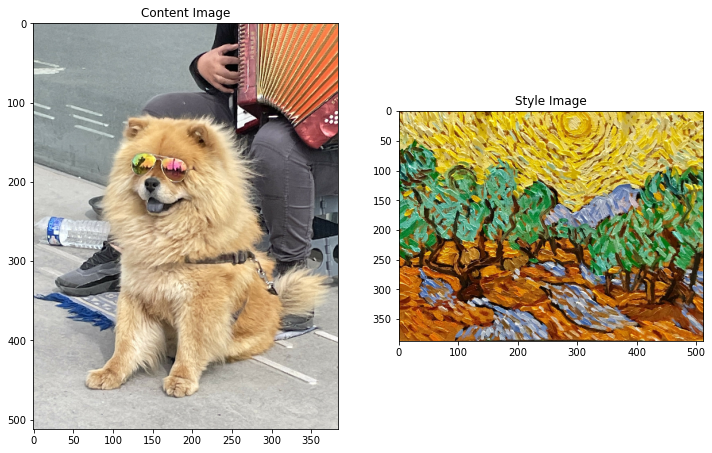

In [7]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

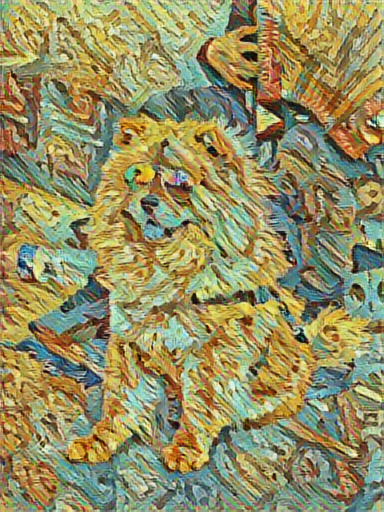

In [8]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

_____

In [9]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [10]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('Pomeranian', 0.64098126),
 ('chow', 0.34813473),
 ('keeshond', 0.007598126),
 ('muzzle', 0.0014091061),
 ('Pekinese', 0.000597072)]

In [11]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [12]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [13]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [14]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 387, 512, 64)
  min:  0.0
  max:  812.2899
  mean:  40.92901

block2_conv1
  shape:  (1, 193, 256, 128)
  min:  0.0
  max:  4012.609
  mean:  222.19974

block3_conv1
  shape:  (1, 96, 128, 256)
  min:  0.0
  max:  9704.384
  mean:  235.82062

block4_conv1
  shape:  (1, 48, 64, 512)
  min:  0.0
  max:  22162.418
  mean:  811.45416

block5_conv1
  shape:  (1, 24, 32, 512)
  min:  0.0
  max:  4291.255
  mean:  54.069195



In [15]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [16]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [17]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.05344348
    max:  38900.34
    mean:  449.76538

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  122376.91
    mean:  16213.166

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  400031.84
    mean:  16472.17

   block4_conv1
    shape:  (1, 512, 512)
    min:  3.797609
    max:  2858503.8
    mean:  247790.9

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  148019.4
    mean:  2562.3975

Contents:
   block5_conv2
    shape:  (1, 32, 24, 512)
    min:  0.0
    max:  2110.0344
    mean:  20.912453


In [18]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [19]:
image = tf.Variable(content_image)

In [20]:
image

<tf.Variable 'Variable:0' shape=(1, 512, 384, 3) dtype=float32, numpy=
array([[[[0.5786765 , 0.6178922 , 0.6218138 ],
         [0.5916667 , 0.6308824 , 0.6387255 ],
         [0.58439034, 0.623606  , 0.63144916],
         ...,
         [0.64126843, 0.46078435, 0.25507048],
         [0.69342834, 0.5130362 , 0.3169577 ],
         [0.7933518 , 0.59630823, 0.39039525]],

        [[0.59367347, 0.63288915, 0.6368107 ],
         [0.58700985, 0.62622553, 0.63406867],
         [0.5808824 , 0.62009805, 0.6279412 ],
         ...,
         [0.6522059 , 0.48357844, 0.2757353 ],
         [0.6912071 , 0.5068934 , 0.29681373],
         [0.72809434, 0.49211094, 0.28270528]],

        [[0.59681374, 0.6360294 , 0.639951  ],
         [0.5889706 , 0.6281863 , 0.6360294 ],
         [0.58357847, 0.62279415, 0.6306373 ],
         ...,
         [0.82192105, 0.644853  , 0.430959  ],
         [0.7666974 , 0.5622549 , 0.3387255 ],
         [0.8463236 , 0.57238054, 0.34420955]],

        ...,

        [[0.83889407,

In [21]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [22]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [23]:
style_weight=1e-2
content_weight=1e4

In [24]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [25]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

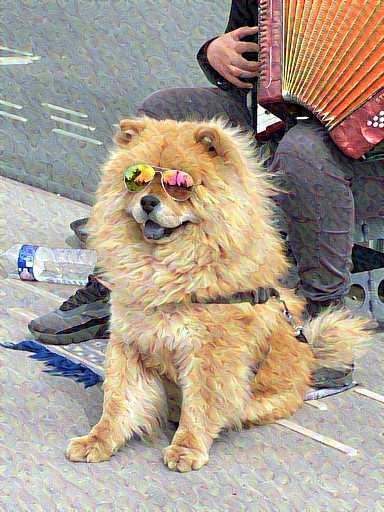

In [26]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

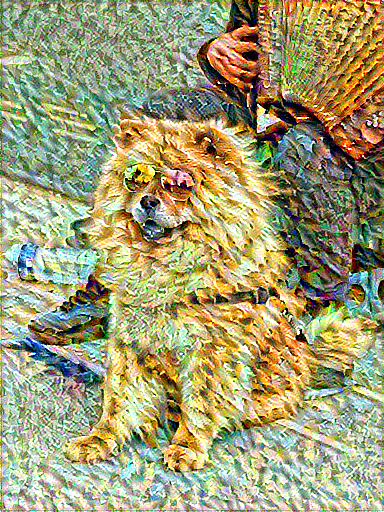

Train step: 100
Total time: 143.1


In [27]:
import time
start = time.time()

epochs = 1
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

_____

In [28]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

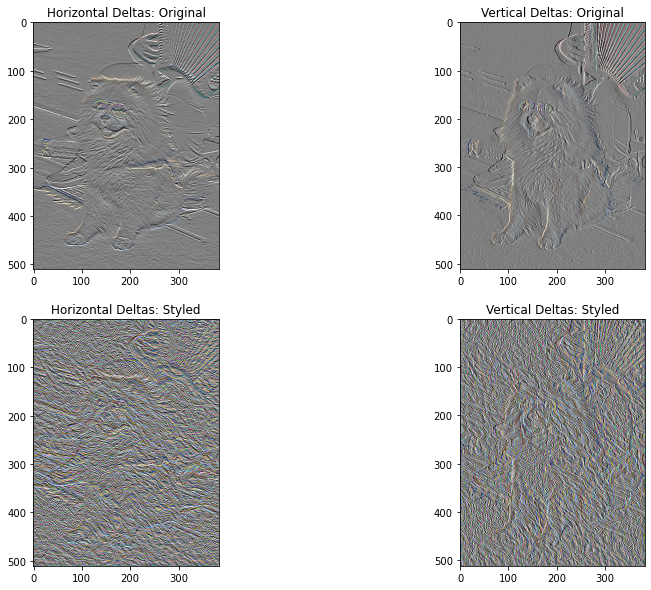

In [29]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

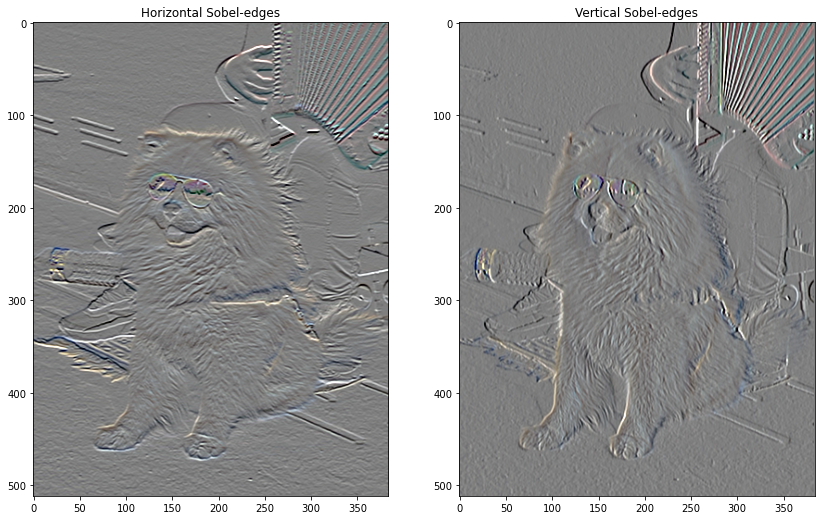

In [30]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

In [31]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [32]:
total_variation_loss(image).numpy()

159966.06

In [33]:
tf.image.total_variation(image).numpy()

array([159966.06], dtype=float32)

In [34]:
total_variation_weight=30

In [35]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [36]:
image = tf.Variable(content_image)

In [37]:
import time
start = time.time()

epochs = 1
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

KeyError: in user code:

    File "C:\Users\rcolm\AppData\Local\Temp\ipykernel_16392\4152216856.py", line 9, in train_step  *
        opt.apply_gradients([(grad, image)])
    File "C:\Users\rcolm\anaconda3\lib\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 1140, in apply_gradients  **
        return super().apply_gradients(grads_and_vars, name=name)
    File "C:\Users\rcolm\anaconda3\lib\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 634, in apply_gradients
        iteration = self._internal_apply_gradients(grads_and_vars)
    File "C:\Users\rcolm\anaconda3\lib\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 1166, in _internal_apply_gradients
        return tf.__internal__.distribute.interim.maybe_merge_call(
    File "C:\Users\rcolm\anaconda3\lib\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 1216, in _distributed_apply_gradients_fn
        distribution.extended.update(
    File "C:\Users\rcolm\anaconda3\lib\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 1213, in apply_grad_to_update_var  **
        return self._update_step(grad, var)
    File "C:\Users\rcolm\anaconda3\lib\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 216, in _update_step
        raise KeyError(

    KeyError: 'The optimizer cannot recognize variable Variable:0. This usually means you are trying to call the optimizer to update different parts of the model separately. Please call `optimizer.build(variables)` with the full list of trainable variables before the training loop or use legacy optimizer `tf.keras.optimizers.legacy.{self.__class__.__name__}.'


_____________